In [290]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [291]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'

In [292]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [293]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [294]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
5    0.146963
6    0.146963
1    0.145272
4    0.143920
2    0.142060
3    0.138002
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [295]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


In [ ]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [297]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


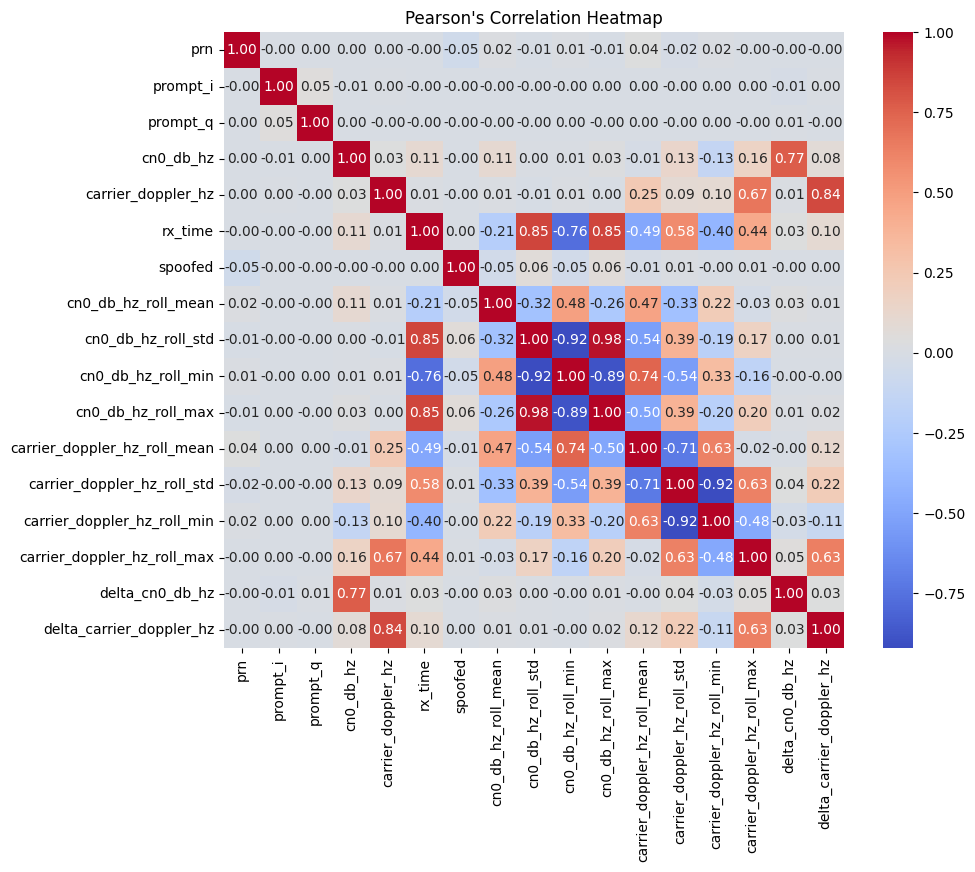

In [298]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [299]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [300]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [301]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [302]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [304]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

window_size = 200

big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df['prompt_magnitude_roll_std'] = big_df['prompt_magnitude'].rolling(window_size).std().fillna(0)

big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df_no_diff['prompt_magnitude_roll_std'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).std().fillna(0)

C:\Users\nicho\AppData\Local\Temp\ipykernel_42848\1966035315.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
C:\Users\nicho\AppData\Local\Temp\ipykernel_42848\1966035315.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')


In [305]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [306]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


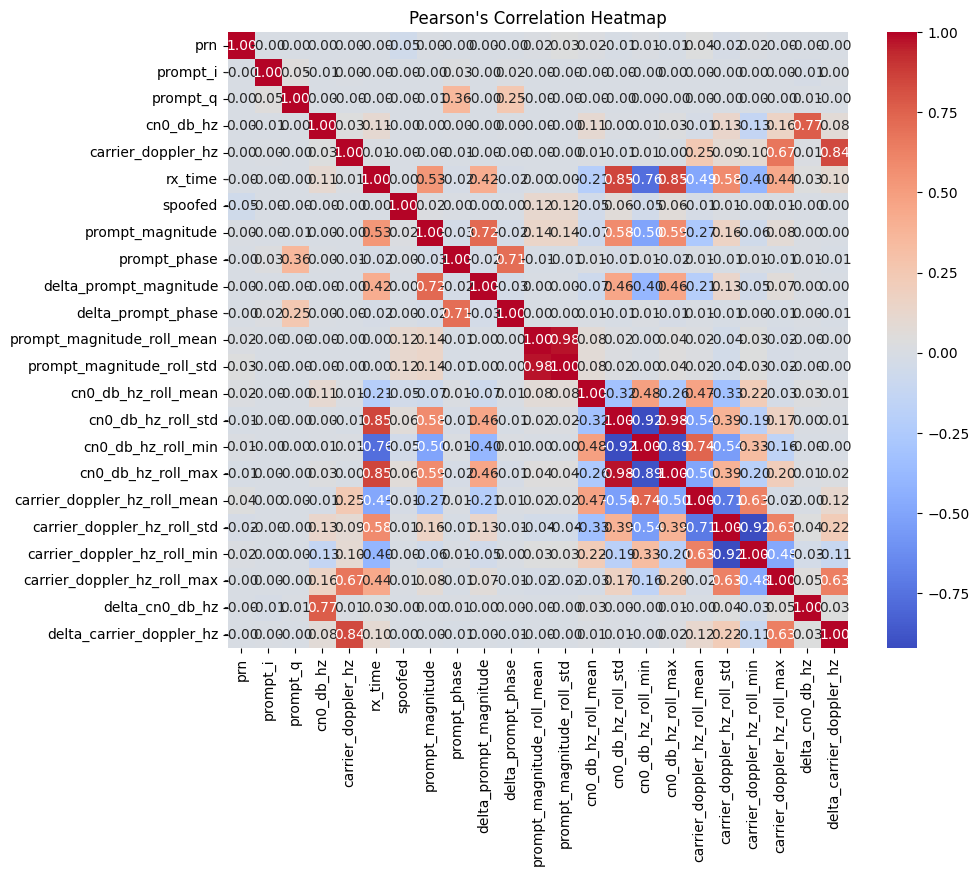

In [307]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [308]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

In [309]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [310]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [311]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [312]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [313]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,...,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,prompt_magnitude_roll_std
166495,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189
161680,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189
128872,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189
47992,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189
156348,-1.834977,-0.435739,-2.640442,0.065278,2.356523,0.822074,2.099307,-1.854851,1.535759,-1.171081,...,-0.193146,0.299294,-3.120579,0.096751,1.656178,-4.320187,2.323255e-02,-2.870588,3.384393,2.831186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35762,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189
157503,0.036498,-0.160423,3.016729,0.037191,2.356523,1.392871,2.734591,-1.879696,2.361787,-1.054477,...,-0.249510,0.447901,-1.025104,-0.258299,-0.186092,-0.128796,2.687027e-02,-1.714839,1.436165,1.078196
187664,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189
84819,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.103927,-0.355492,0.320892,-0.343204,0.186683,...,0.057621,-0.063803,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.332330,-0.345189


In [314]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,...,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
151730,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.593445,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424
152694,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-3.491310,3.050930e+00,1.216810,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424
84540,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.612049,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424
183538,-0.000203,0.080115,1.343262,-0.088888,2.356523,-0.221852,2.311832,0.001245,1.630750e+00,-1.443052,...,0.184231,2.004665,-1.955765,1.843569,-1.699478,0.502886,-0.164594,0.242010,0.134469,0.019437
51685,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-1.448643,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154398,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.317559,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424
23395,-4.569382,-0.700701,-1.292548,-0.116091,2.356523,4.457464,-4.322767,3.230325,-3.060548e+00,1.197349,...,-4.211705,4.041713,-3.913780,3.969232,-1.955311,0.717489,-0.188684,0.313986,-3.081176,-0.069583
131434,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.008099,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424
142386,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.594380,...,0.103927,-0.355492,0.320892,-0.343204,0.186683,-0.133701,0.057621,-0.063803,-0.000618,-0.001424


In [315]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
6    0.147845
5    0.147234
1    0.145996
4    0.144088
2    0.141967
3    0.136526
0    0.136344
Name: proportion, dtype: float64
spoofed
5    0.146144
6    0.145193
4    0.143978
1    0.143238
2    0.142287
3    0.140385
0    0.138774
Name: proportion, dtype: float64


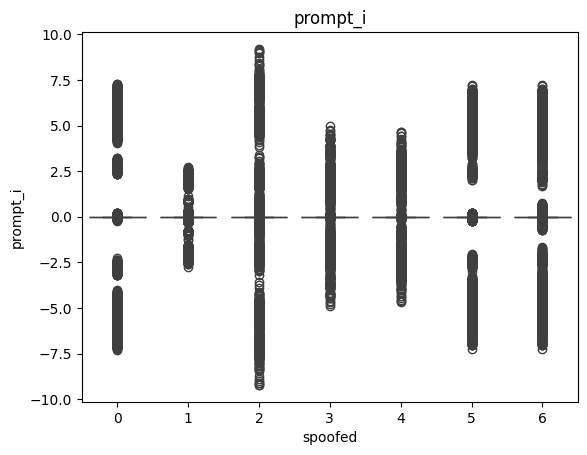

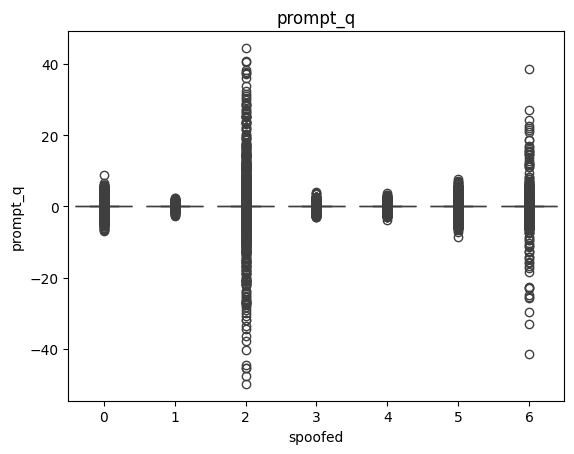

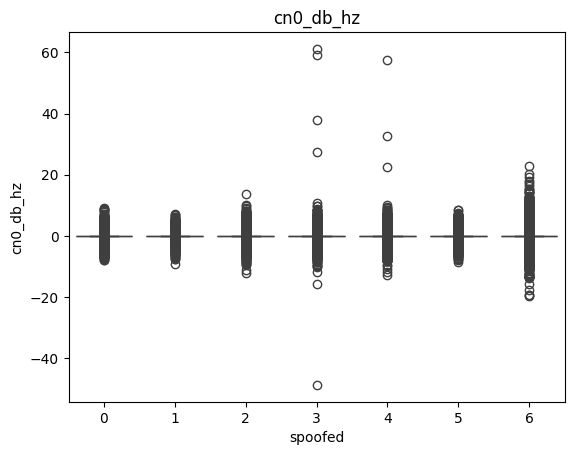

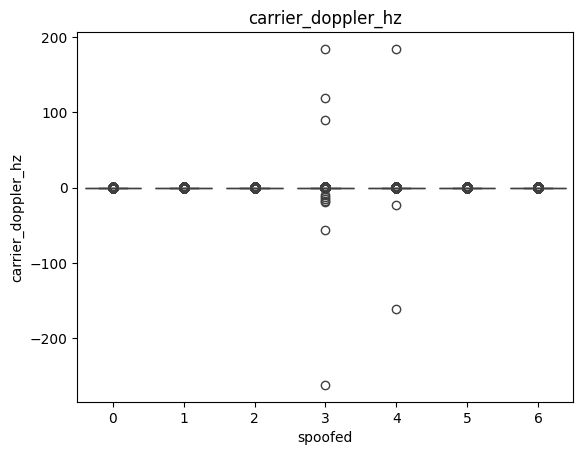

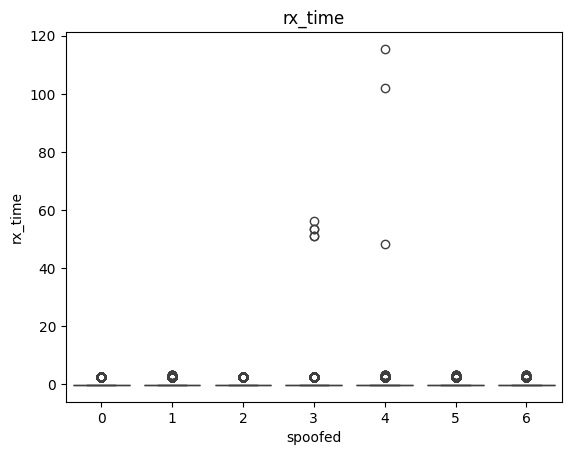

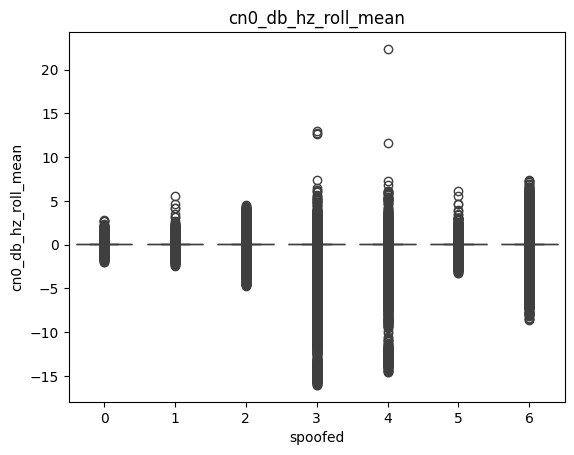

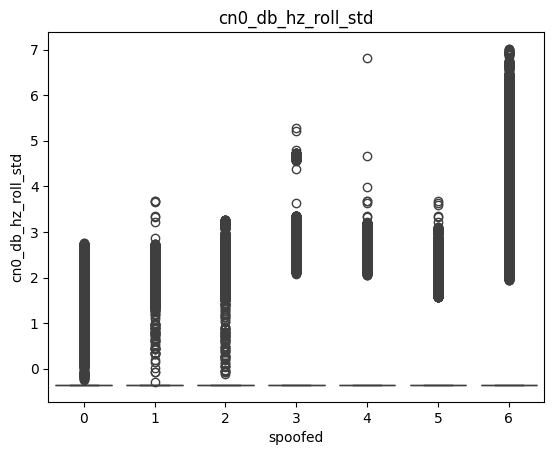

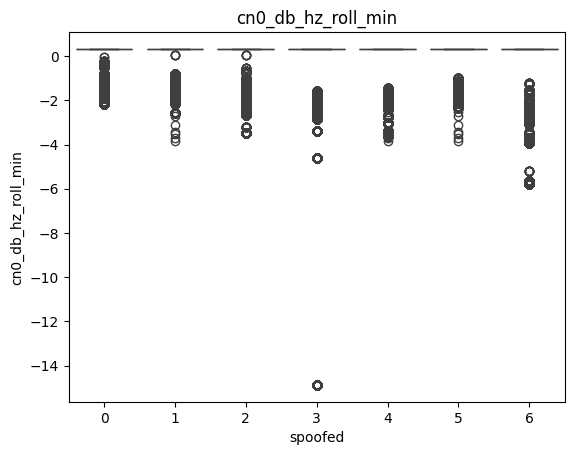

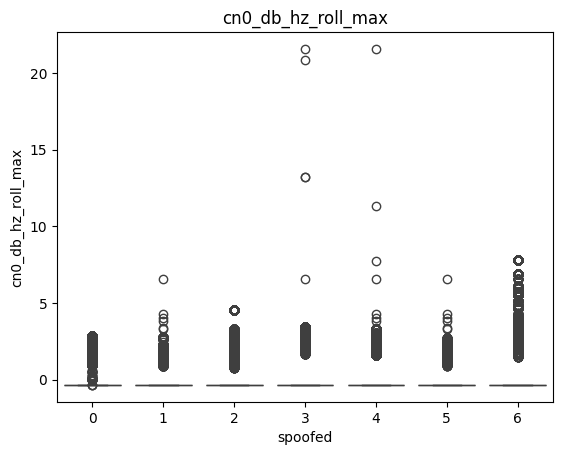

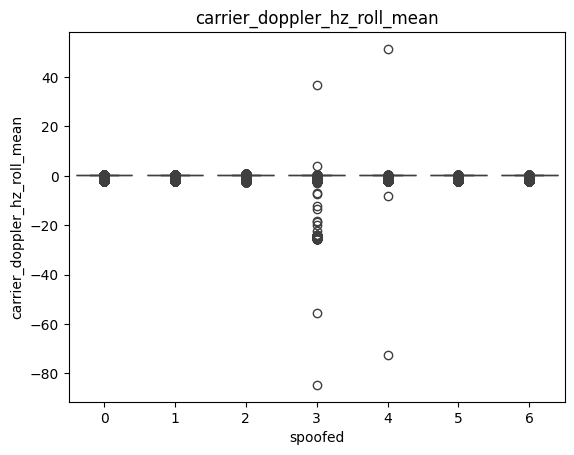

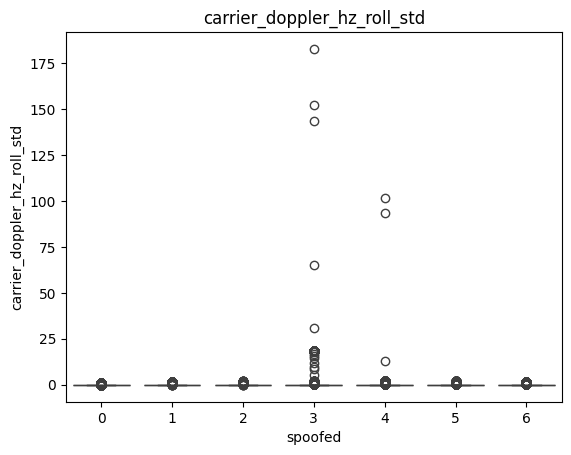

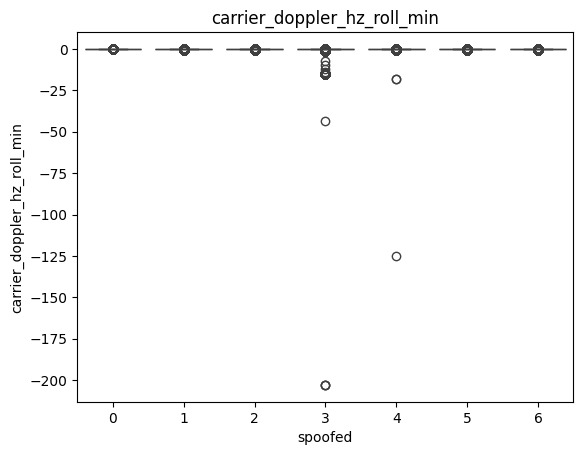

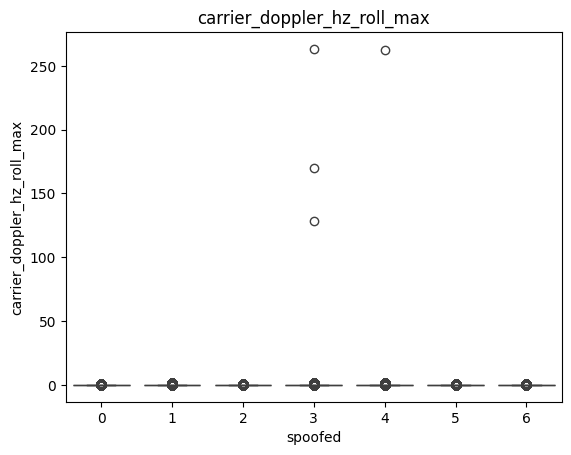

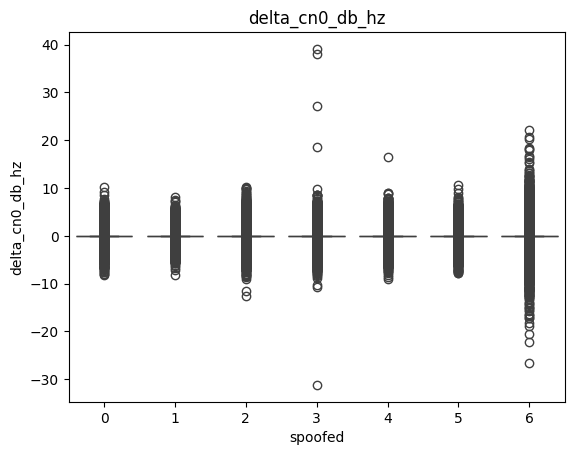

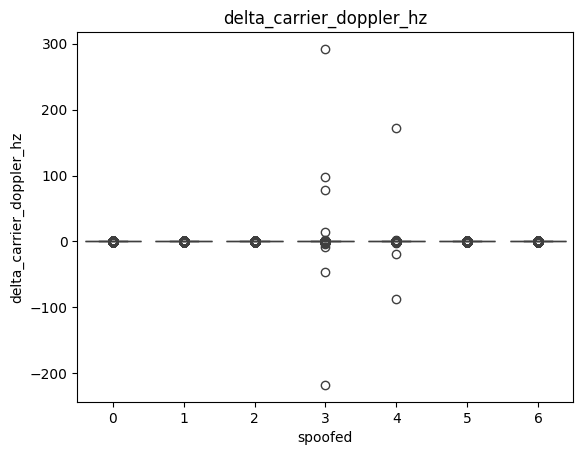

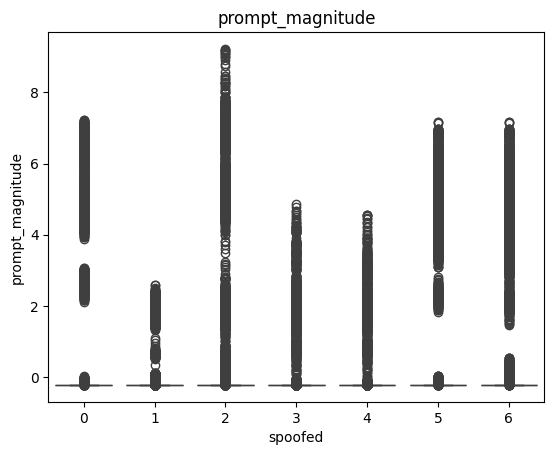

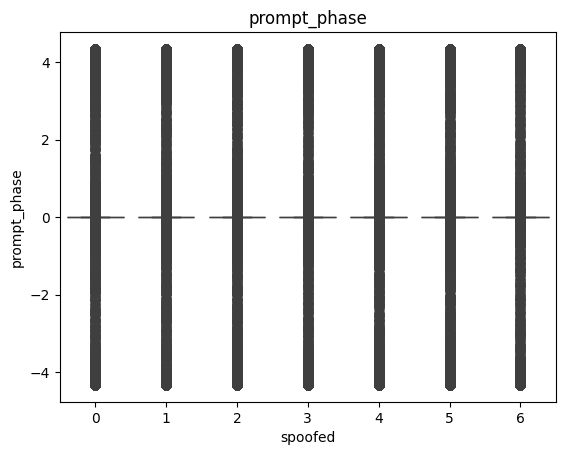

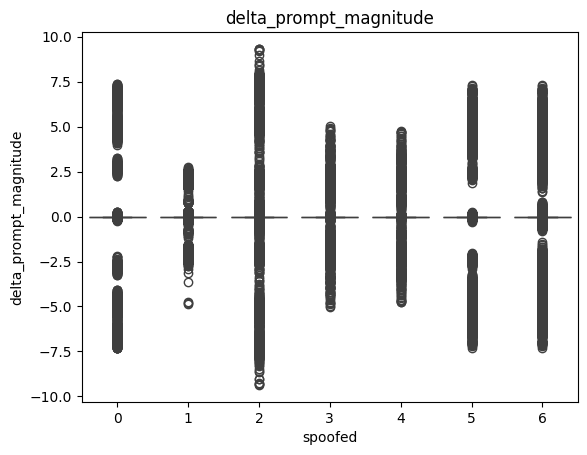

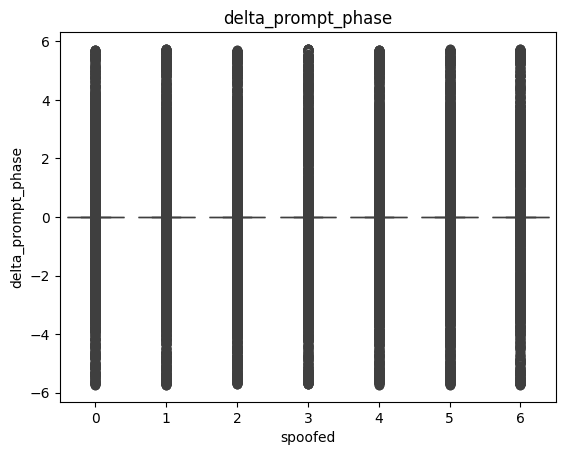

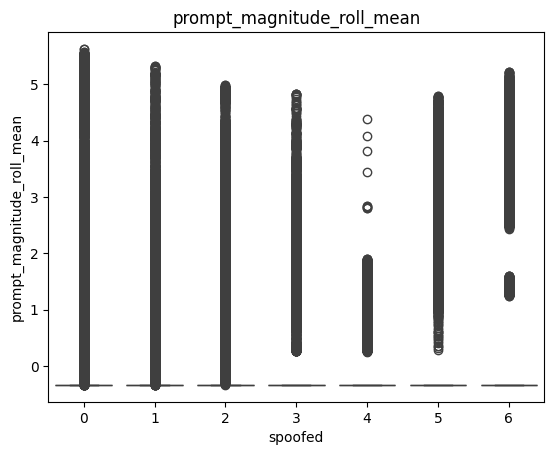

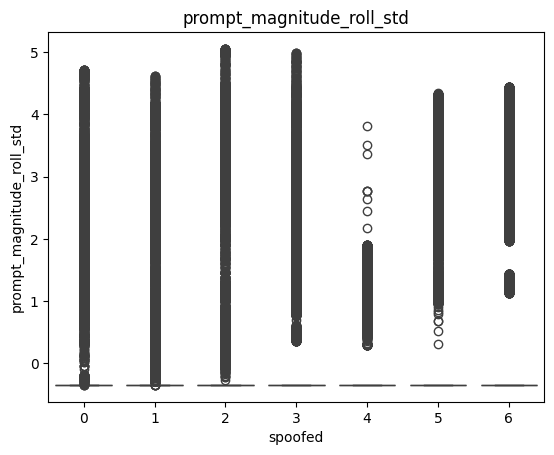

In [316]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [317]:
svm = SVC(kernel='rbf', C=1.0, class_weight='balanced')
svm.fit(X_train, y_train)


SVC(class_weight='balanced')

In [318]:
svm_no_diff = SVC(kernel='rbf', C=1.0, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)


SVC(class_weight='balanced')

In [319]:
y_pred = svm.predict(X_test)


In [320]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.71      0.14      0.23      5253
           1       0.84      0.12      0.21      5422
           2       0.79      0.08      0.15      5386
           3       0.15      0.95      0.26      5314
           4       0.72      0.11      0.19      5450
           5       0.68      0.09      0.16      5532
           6       0.95      0.09      0.16      5496

    accuracy                           0.22     37853
   macro avg       0.69      0.23      0.19     37853
weighted avg       0.69      0.22      0.19     37853



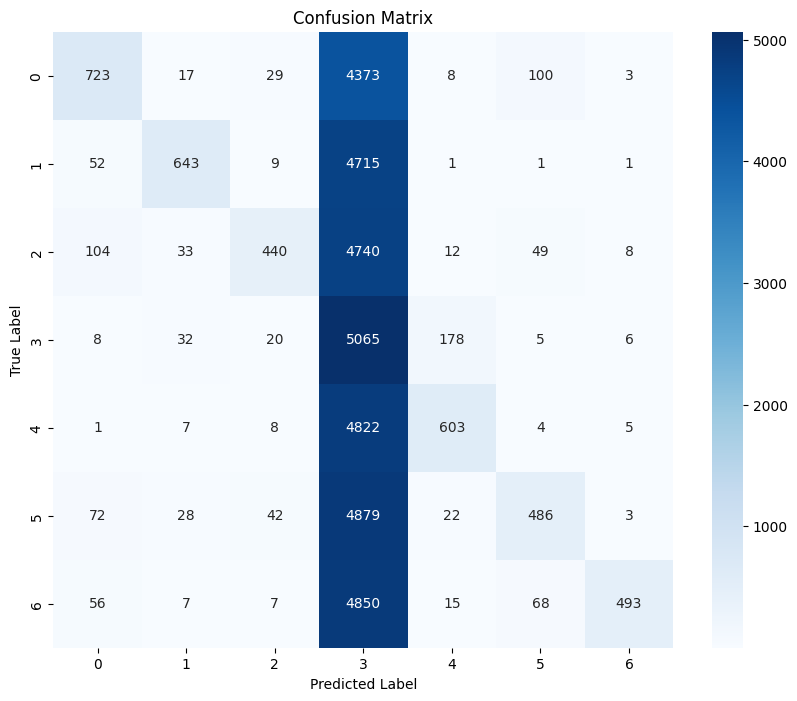

In [321]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.46      0.40      0.43      5209
           1       0.84      0.77      0.80      5507
           2       0.56      0.43      0.49      5459
           3       0.38      0.41      0.40      5250
           4       0.42      0.63      0.50      5349
           5       0.35      0.26      0.30      5563
           6       0.45      0.51      0.48      5516

    accuracy                           0.49     37853
   macro avg       0.49      0.49      0.48     37853
weighted avg       0.49      0.49      0.49     37853



Text(95.72222222222221, 0.5, 'True Label')

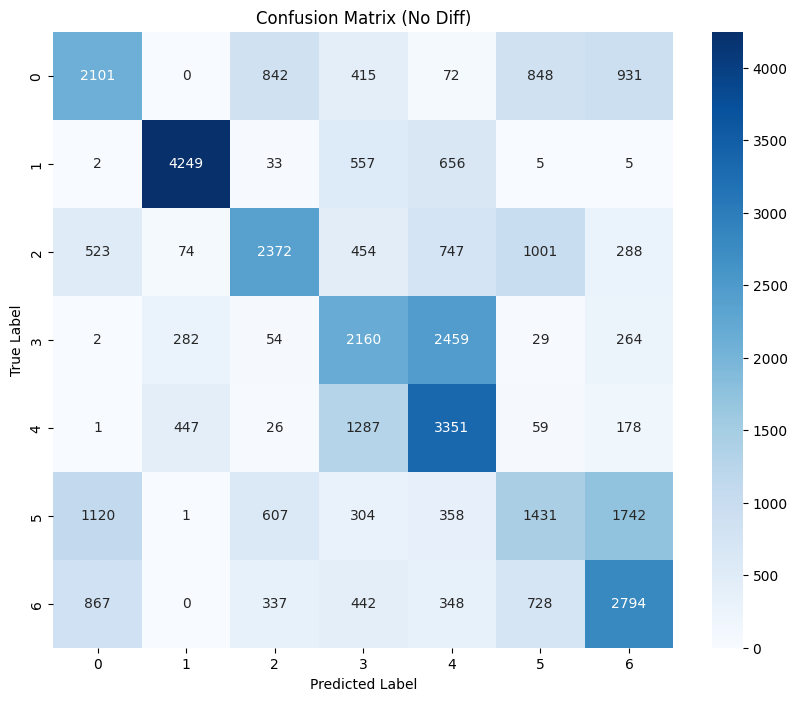

In [322]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [323]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0104
prompt_q: 0.0161
cn0_db_hz: 0.0026
carrier_doppler_hz: 0.0028
rx_time: 0.0036
cn0_db_hz_roll_mean: 0.0341
cn0_db_hz_roll_std: 0.1227
cn0_db_hz_roll_min: 0.0956
cn0_db_hz_roll_max: 0.1082
carrier_doppler_hz_roll_mean: 0.0471
carrier_doppler_hz_roll_std: 0.0889
carrier_doppler_hz_roll_min: 0.0825
carrier_doppler_hz_roll_max: 0.0719
delta_cn0_db_hz: 0.0023
delta_carrier_doppler_hz: 0.0026
prompt_magnitude: 0.0462
prompt_phase: 0.0025
delta_prompt_magnitude: 0.0171
delta_prompt_phase: 0.0022
prompt_magnitude_roll_mean: 0.1180
prompt_magnitude_roll_std: 0.1223

Random Forest No Diff
prompt_i: 0.0008
prompt_q: 0.0009
cn0_db_hz: 0.0004
carrier_doppler_hz: 0.0005
rx_time: 0.0004
cn0_db_hz_roll_mean: 0.0035
cn0_db_hz_roll_std: 0.0003
cn0_db_hz_roll_min: 0.0310
cn0_db_hz_roll_max: 0.0229
carrier_doppler_hz_roll_mean: 0.4060
carrier_doppler_hz_roll_std: 0.4497
carrier_doppler_hz_roll_min: 0.0049
carrier_doppler_hz_roll_max: 0.0140
delta_cn0_db_hz: 0.0124
delta_carri

In [324]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.98      0.18      0.30      5253
           1       0.99      0.13      0.23      5422
           2       0.99      0.12      0.22      5386
           3       0.16      1.00      0.27      5314
           4       1.00      0.12      0.22      5450
           5       0.99      0.12      0.21      5532
           6       0.99      0.12      0.22      5496

    accuracy                           0.25     37853
   macro avg       0.87      0.26      0.24     37853
weighted avg       0.87      0.25      0.24     37853



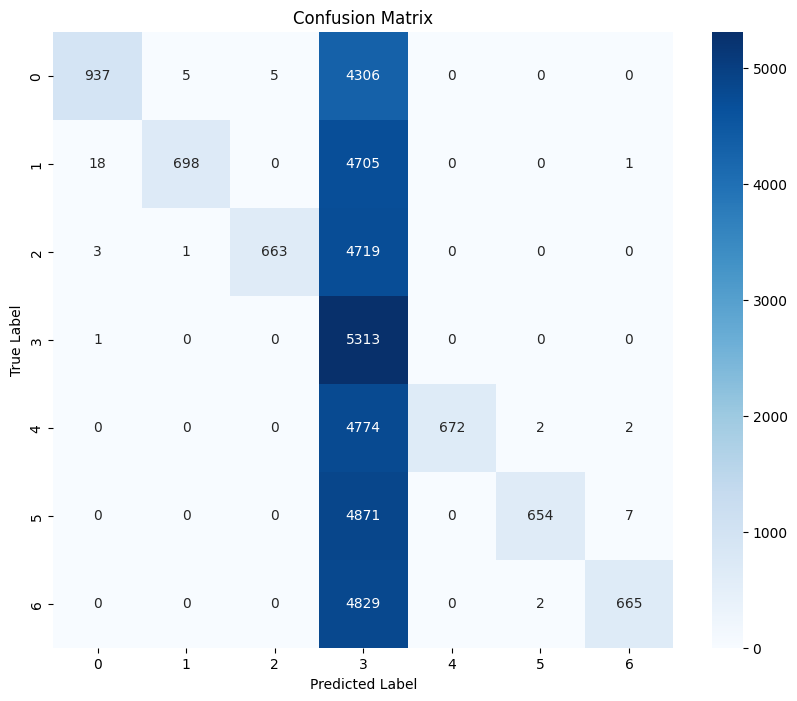

In [325]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.18      0.30      5253
           1       0.99      0.13      0.23      5422
           2       0.99      0.12      0.22      5386
           3       0.16      1.00      0.27      5314
           4       1.00      0.12      0.22      5450
           5       0.99      0.12      0.21      5532
           6       0.99      0.12      0.22      5496

    accuracy                           0.25     37853
   macro avg       0.87      0.26      0.24     37853
weighted avg       0.87      0.25      0.24     37853



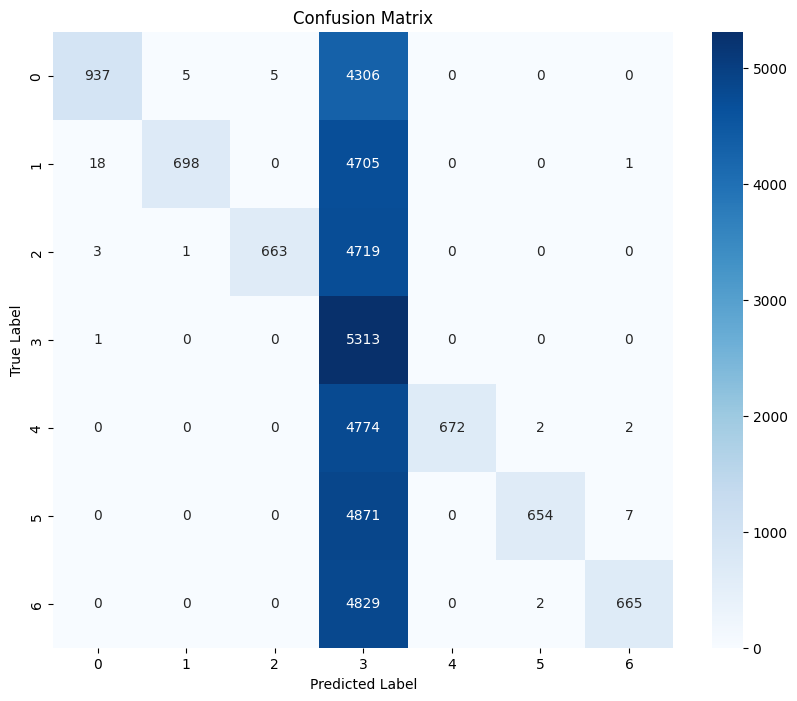

In [326]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

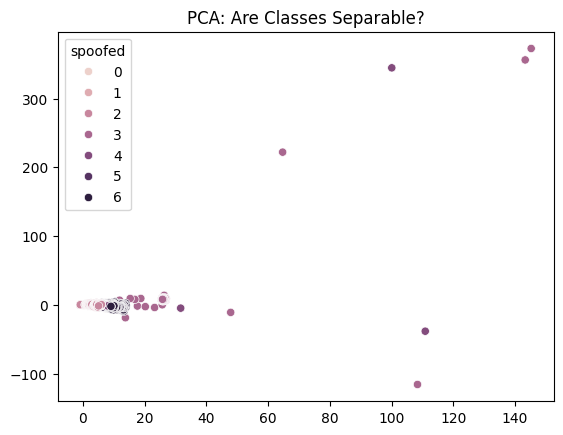

In [327]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()
